# Model-based Optimization using Variational Auto-Encoders

This notebook contains the source code for the Medium article _Optimize What You Can Predict: Model-Based Optimization Using Variational Auto-Encoders_. We first build and train a multi-head Variational Autoencoder. Then we implement methods to navigate in the latent space such that the output of certain predictive models is optimized.

## Imports

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from skimage import morphology, transform
from tqdm.notebook import tqdm

## Hyper-parameters

In [2]:
# helper function
def dim_after_convs():
    """
    Compute the (flattened) dimensionality of the tensor after the convolutional part of the encoder,
    as well as the single-axis dimensionality.
    """
    dim = INP_HEIGHT
    for _ in ENC_CONV_LAYER_CHANNELS[1:]:
        dim = math.floor(1 + (dim - KERNEL_SIZE) / STRIDE)
    flattened_dim = (dim ** 2) * ENC_CONV_LAYER_CHANNELS[-1]
    return flattened_dim, dim

In [3]:
# folders
DATA_DIR = "./data"

# data
NUM_CLASSES = 10
NUM_CHANNELS = 1
INP_HEIGHT = 28
INP_WIDTH = 28
INP_DIM = INP_WIDTH * INP_HEIGHT

# training
BATCH_SIZE = 512
INIT_LR = 1e-3
LR_DECAY_GAMMA = 0.5
LR_DECAY_STEPS = 5
KLD_BETA = 1e-4
NUM_EPOCHS = 60
OPTIMIZER = Adam

# architecture
EMBEDDING_DIM = 16
KERNEL_SIZE = 4
STRIDE = 2
ENC_CONV_LAYER_CHANNELS = [NUM_CHANNELS, 64, 128]
FL_DIM_AFTER_CONV, SINGLE_DIM_AFTER_CONV = dim_after_convs()
ENC_DENSE_LAYER_SIZES = [FL_DIM_AFTER_CONV, 200, EMBEDDING_DIM]
DEC_DENSE_LAYER_SIZES = [EMBEDDING_DIM, 200, FL_DIM_AFTER_CONV]
DEC_CONV_LAYER_CHANNELS = [ENC_CONV_LAYER_CHANNELS[-1], 64, NUM_CHANNELS]
DIGIT_LAYER_SIZES = [EMBEDDING_DIM, 64, NUM_CLASSES]
THICKNESS_LAYER_SIZES = [EMBEDDING_DIM, 64, 1]

## Data

In [4]:
class DigitThicknessSet(Dataset):
    
    def __init__(self, train: bool):
        self.data_set = datasets.MNIST(DATA_DIR, train=train, download=True)
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize((0.1307,), (0.3081,))
        
        # pre-compute thickness for each digit
        self.thickness_map = {}
        for i, (img, _) in enumerate(tqdm(self.data_set)):
            self.thickness_map[i] = self._mean_thickness(img)
        
    def __getitem__(self, index):
        img, digit = self.data_set[index]
        thickness = self.thickness_map[index]
        img = self.normalize(self.to_tensor(img))
        return img, digit, thickness
    
    def __len__(self):
        return len(self.data_set)
        
    def _mean_thickness(self, img, upscale=3, thresh=0.5):
        img = np.array(img)
        img = transform.pyramid_expand(img, upscale=upscale, order=3, multichannel=False)
        img_min, img_max = img.min(), img.max()
        bin_img = (img >= img_min + (img_max - img_min) * thresh)
        skeleton, dist_map = morphology.medial_axis(bin_img, return_distance=True)
        return 2. * np.mean(dist_map[skeleton]) / upscale

In [5]:
def load_data():
    train_set = DataLoader(DigitThicknessSet(train=True), batch_size=BATCH_SIZE, shuffle=True)
    test_set = DataLoader(DigitThicknessSet(train=False), batch_size=BATCH_SIZE)
    return train_set, test_set

## Model definition

In [6]:
class VariationalEncoder(nn.Module):
    
    def __init__(self):
        super(VariationalEncoder, self).__init__()
        self.create_network()

    def create_network(self):
        
        # convolutional part
        for i in range(1, len(ENC_CONV_LAYER_CHANNELS)):
            self.add_module(f"enc_conv_{i}", nn.Conv2d(in_channels=ENC_CONV_LAYER_CHANNELS[i - 1],
                                                       out_channels=ENC_CONV_LAYER_CHANNELS[i],
                                                       kernel_size=KERNEL_SIZE, stride=STRIDE))
            self.add_module(f"enc_conv_activation_{i}", nn.ReLU())
            
        # fully-connected part
        for i in range(1, len(ENC_DENSE_LAYER_SIZES)):
            if i == len(ENC_DENSE_LAYER_SIZES) - 1:
                self.add_module('mu', nn.Linear(ENC_DENSE_LAYER_SIZES[i - 1],
                                                ENC_DENSE_LAYER_SIZES[i], bias=True))
                self.add_module('logvar', nn.Linear(ENC_DENSE_LAYER_SIZES[i - 1],
                                                    ENC_DENSE_LAYER_SIZES[i], bias=True))
            else:
                self.add_module(f"enc_linear_{i}", nn.Linear(ENC_DENSE_LAYER_SIZES[i - 1],
                                                             ENC_DENSE_LAYER_SIZES[i], bias=True))
                self.add_module(f"enc_linear_activation_{i}", nn.ReLU())

    def forward(self, inp):
        tmp = inp
        for mod_name, module in self._modules.items():
            if mod_name == 'mu':
                mu = module(tmp)
            elif mod_name == 'logvar':
                logvar = module(tmp)
            elif mod_name == 'enc_linear_1':
                tmp = module(torch.flatten(tmp, start_dim=1))
            else:
                tmp = module(tmp)
        return mu, logvar

In [7]:
class Decoder(nn.Module):

    def __init__(self):
        super(Decoder, self).__init__()
        self.create_network()

    def create_network(self):
        
        # fully-connected part
        for i in range(1, len(DEC_DENSE_LAYER_SIZES)):
            self.add_module(f"dec_linear_{i}", nn.Linear(DEC_DENSE_LAYER_SIZES[i - 1],
                                                         DEC_DENSE_LAYER_SIZES[i], bias=True))
            self.add_module(f"dec_linear_activitation_{i}", nn.ReLU())
            
        # convolutional part
        for i in range(1, len(DEC_CONV_LAYER_CHANNELS)):
            if i == len(DEC_CONV_LAYER_CHANNELS) - 1:
                self.add_module(f"dec_conv_{i}", nn.ConvTranspose2d(DEC_CONV_LAYER_CHANNELS[i - 1],
                                                                    DEC_CONV_LAYER_CHANNELS[i],
                                                                    KERNEL_SIZE, STRIDE))
            else:
                self.add_module(f"dec_conv_{i}", nn.ConvTranspose2d(DEC_CONV_LAYER_CHANNELS[i - 1],
                                                                    DEC_CONV_LAYER_CHANNELS[i],
                                                                    KERNEL_SIZE, STRIDE, output_padding=1))
                self.add_module(f"dec_conv_activitation_{i}", nn.ReLU())
            
    def forward(self, inp):
        tmp = inp
        for mod_name, module in self._modules.items():
            if mod_name == 'dec_conv_1':
                tmp = tmp.view([-1, ENC_CONV_LAYER_CHANNELS[-1], SINGLE_DIM_AFTER_CONV, SINGLE_DIM_AFTER_CONV])
            tmp = module(tmp)
        return tmp

In [8]:
class DigitClassifier(nn.Module):

    def __init__(self):
        super(DigitClassifier, self).__init__()
        self.create_network()

    def create_network(self):
        for i in range(1, len(DIGIT_LAYER_SIZES)):
            if i == len(DIGIT_LAYER_SIZES) - 1:
                self.add_module(f"clf_linear_{i}", nn.Linear(DIGIT_LAYER_SIZES[i - 1],
                                                             DIGIT_LAYER_SIZES[i], bias=True))
                self.add_module("clf_out", nn.LogSoftmax(dim=1))
            else:
                self.add_module(f"clf_linear_{i}", nn.Linear(DIGIT_LAYER_SIZES[i - 1],
                                                             DIGIT_LAYER_SIZES[i], bias=True))
                self.add_module(f"clf_activitation_{i}", nn.ReLU())

    def forward(self, inp):
        tmp = inp
        for mod_name, module in self._modules.items():
            tmp = module(tmp)
        return tmp

In [9]:
class ThicknessModel(nn.Module):

    def __init__(self):
        super(ThicknessModel, self).__init__()
        self.create_network()

    def create_network(self):
        for i in range(1, len(THICKNESS_LAYER_SIZES)):
            if i == len(THICKNESS_LAYER_SIZES) - 1:
                self.add_module(f"clf_t_linear_{i}", nn.Linear(THICKNESS_LAYER_SIZES[i - 1],
                                                               THICKNESS_LAYER_SIZES[i], bias=True))
            else:
                self.add_module(f"clf_t_linear_{i}", nn.Linear(THICKNESS_LAYER_SIZES[i - 1],
                                                               THICKNESS_LAYER_SIZES[i], bias=True))
                self.add_module(f"clf_t_activitation_{i}", nn.ReLU())

    def forward(self, inp):
        tmp = inp
        for mod_name, module in self._modules.items():
            tmp = module(tmp)
        return tmp

In [10]:
class BetaKLDLoss:
    
    def __init__(self, beta):
        self.beta = beta    
        
    def __call__(self, mu, logvar):
        kld = - 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return self.beta * kld

In [11]:
def accuracy(ref, pred):
    return accuracy_score(ref, torch.argmax(pred, 1))

def l2_reconstruction_error(ref, pred):
    return mean_squared_error(torch.flatten(ref), torch.flatten(pred))    

In [12]:
class VAE(nn.Module):
    
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = VariationalEncoder()
        self.decoder = Decoder()
        self.classifier = DigitClassifier()
        self.thickness_model = ThicknessModel()
        
        self.clf_loss = nn.NLLLoss()
        self.t_loss = nn.MSELoss()
        self.dec_loss = nn.MSELoss()
        self.kld_loss = BetaKLDLoss(beta=KLD_BETA)

    def forward(self, inp):
        mu, logvar = self.encoder(inp)
        emb = self._reparameterize(mu, logvar)
        inp_hat = self.decoder(emb)
        t_hat = self.thickness_model(emb)
        y_hat = self.classifier(emb)
        return inp_hat, y_hat, t_hat, mu, logvar
        
    def _reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def train_(self, train_data_loader):
        
        trainable_params = list(self.encoder.parameters()) + list(self.decoder.parameters()) \
                            + list(self.classifier.parameters()) + list(self.thickness_model.parameters())
        optimizer = OPTIMIZER(trainable_params, INIT_LR)
        scheduler = StepLR(optimizer, step_size=LR_DECAY_STEPS, gamma=LR_DECAY_GAMMA)
        
        for epoch in range(1, NUM_EPOCHS + 1):
            for inp_batch, y_batch, t_batch in tqdm(train_data_loader):
                self.train()
                optimizer.zero_grad()
                inp_hat_batch, y_hat_batch, t_hat_batch, mu, logvar = self.forward(inp_batch)
                total_loss = self.clf_loss(y_hat_batch, y_batch) + \
                             self.dec_loss(inp_hat_batch, inp_batch) + \
                             self.t_loss(torch.squeeze(t_hat_batch), t_batch) + \
                             self.kld_loss(mu, logvar)
                total_loss.backward()
                optimizer.step()
            scheduler.step()

    def eval_(self, test_data_loader):
        with torch.no_grad():
            inp_batch, y_batch, t_batch = next(iter(test_data_loader))            
            inp_hat_batch, y_hat_batch, t_hat_batch,  _, _ = self.forward(inp_batch)
            t_error = mean_absolute_error(t_batch, t_hat_batch)
            acc = accuracy(y_batch, y_hat_batch)
            rec_err = l2_reconstruction_error(inp_batch, inp_hat_batch)
            print(f"The mean classification accuracy is {acc}.")
            print(f"The mean reconstruction error is {rec_err}.")
            print(f"The mean absolute thickness error is {t_error}.")

## Training

In [13]:
train_set, test_set = load_data()

In [14]:
model = VAE()
model.train_(train_set)
model.eval_(test_set)


The mean classification accuracy is 0.9765625.
The mean reconstruction error is 0.34404683113098145.
The mean absolute thickness error is 0.17375248670578003.


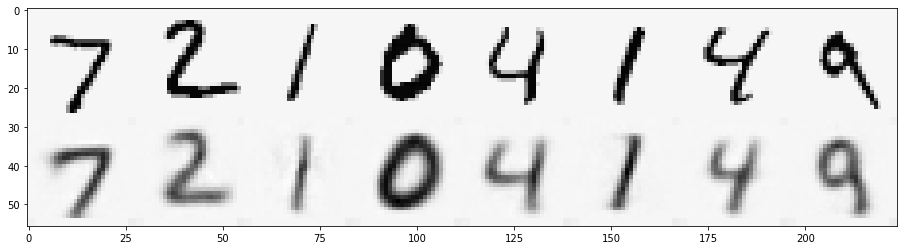

In [15]:
# plot some images
num_samples = 8
x = list(test_set)[0][0][:num_samples]
with torch.no_grad():
    x_hat = model(x)[0]
x_row = torch.squeeze(torch.cat(torch.split(x, 1), 3))
x_hat_row = torch.squeeze(torch.cat(torch.split(x_hat, 1), 3))
img = torch.cat([x_row, x_hat_row], 0)
plt.figure(figsize=(16,4))
plt.imshow(img, cmap='Greys')

## Optimization

In [16]:
def latent_thickness_step(z, t_model, step_size):
    z = z.clone().detach().requires_grad_(True)
    t_model.zero_grad()
    t_hat = t_model(z)
    t_hat[0].backward(retain_graph=True)
    return z + step_size * z.grad

In [17]:
def latent_thickness_optimization(z, model, step_size, n_steps=20):
    x_hats = [model.decoder(z)]
    for step in range(n_steps):
        z = latent_thickness_step(z, model.thickness_model, step_size)
        x_hats.append(model.decoder(z))
    return x_hats

In [18]:
def latent_digit_step(z, clf, target, step_size):
    z = z.clone().detach().requires_grad_(True)
    clf.zero_grad()
    y_hat = clf(z)
    y_hat[0][target].backward(retain_graph=True)
    return z + step_size * z.grad

In [19]:
def latent_digit_optimization(z, model, target, step_size, n_steps=20):
    x_hats = [model.decoder(z)]
    for step in range(n_steps):
        z = latent_digit_step(z, model.classifier, target, step_size)
        x_hats.append(model.decoder(z))
    return x_hats

First, let's pick a random image.

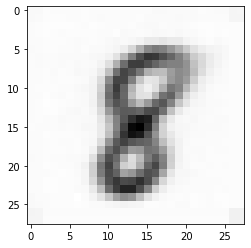

In [20]:
z_start = torch.rand(1, EMBEDDING_DIM)
plt.imshow(model.decoder(z_start).squeeze().detach().numpy(), cmap='Greys')

Now, let's increase the thickness.

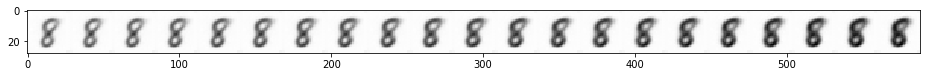

In [21]:
x_hats = latent_thickness_optimization(z_start, model, 0.2)
plt.figure(figsize=(16,4))
plt.imshow(torch.squeeze(torch.cat(x_hats, 3)).detach().numpy(), cmap='Greys')

We can also gradually transform it into another digit.

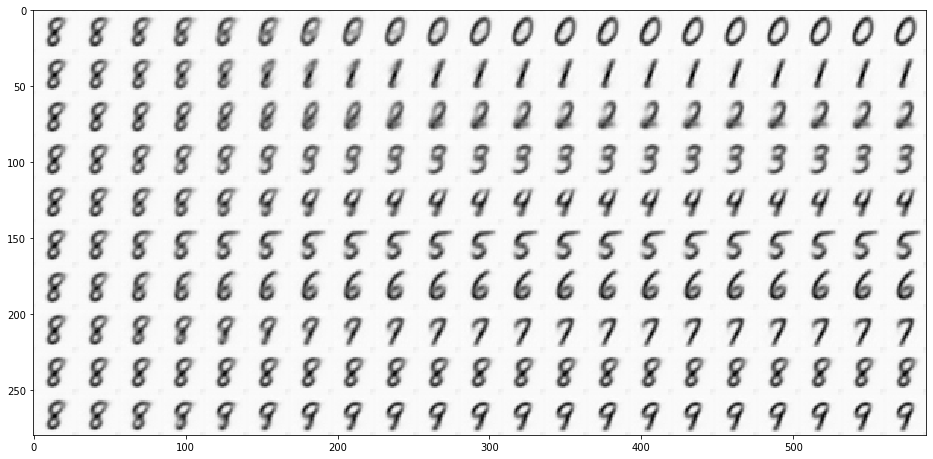

In [22]:
c_x_hats = []
for target_digit in range(NUM_CLASSES):
    x_hats = latent_digit_optimization(z_start, model, target_digit, 0.03)
    c_x_hats.append(x_hats)
imgs = []
for i in range(NUM_CLASSES):
    imgs.append(torch.squeeze(torch.cat(c_x_hats[i], 3)).detach().numpy())
plt.figure(figsize=(16,40))
plt.imshow(np.concatenate(imgs), cmap='Greys')